In [5]:
##########################################################複製區塊
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np
import random
import multiprocessing as multi
#setup some constants and parameters
M=2**21
tsim=7e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=30000
frq_min = 0
frq_max = 100/2/np.pi
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp= 20
nfreq =  1000
#define the starting sum of the result
Efsum = np.zeros(nfreq)
Ens = np.zeros(2**22)
resolution = 10
dpml = 1.0
cell = mp.Vector3(16,8,0)
pml_layers = [mp.PML(dpml)]



for i in range(Ncomp):
    
    def random_En(t):
        #generate random numbers
        M0 = np.random.normal(0,1)
        Mlp = np.random.normal(0,1,M-1)
        Nlp = np.random.normal(0,1,M-1)
        MM = np.random.normal(0,1)
    
        #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
        #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
        #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
        Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
        Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
        Eflm = np.flip(np.conjugate(Eflp))
        EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
        Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
        #we normalize Ef and compute its inverse fast fourier transform
        Efn = deltap*T/np.sqrt(tsim)*Ef
        En = np.fft.ifft(Efn)*M
        return En
    En0 = random_En(1)
    En1 = random_En(1)
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('a'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    
    
    def source0(t):
        f = int(t*2000)
        return En0[f]
    def source1(t):
        f = int(t*2000)
        return En1[f]
    


    sources = [mp.Source(mp.CustomSource(src_func=source0),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,0),
                     ),
              mp.Source(mp.CustomSource(src_func=source1),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,0),
                     )]
    
    geometry = [mp.Block(mp.Vector3(mp.inf,1,0),
                     center=mp.Vector3(),
                     material=mp.Medium(epsilon=1))]
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,   
                    #dimensions = 2,
                    resolution=resolution)
    
    

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,0), size=mp.Vector3(2,0,0))
    tran = sim.add_energy(fcen, df, nfreq, tran_fr)
    
    
    sim.run(until=2090)

    tran_flux = mp.get_magnetic_energy(tran)
    Ts = []
    for i in range(nfreq):
        Ts = np.append(Ts,tran_flux[i])    
    Efsum += Ts
    
    

#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it



[                    ] 0%-----------
Initializing structure...
time for choose_chunkdivision = 0.000212908 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0545661 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 341.65000000000003/2090.0 = 16.3% done in 4.0s, 20.5s to go
on time step 6841 (time=342.05), 0.00058476 s/step
Meep progress: 689.6500000000001/2090.0 = 33.0% done in 8.0s, 16.2s to go
on time step 13803 (time=690.15), 0.000574582 s/step
Meep progress: 1040.45/2090.0 = 49.8% done in 12.0s, 12.1s to go
on time step 20820 (time=1041), 0.000570117 s/step
Meep progress: 1389.5500000000002/2090.0 = 66.5% done in 16.0s, 8.1s to go
on time step 27804 (time=1390.2), 0.000572804 s/step
Meep progress: 1736.2/2090.0 = 83.1% done in 20.0s, 4.1s to go
on time step 34738 (time=1736.9), 0.00057693 s/step
Meep progress: 2082.3/2090.0 = 99.6% done in 24.0s, 0.1s to go
on time step 41661 (time=2083.05), 0.000577864 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaa               ] 5%-----------
Initializing structure...
time for choose_chunkdivision = 0.000187874 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
        

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 350.90000000000003/2090.0 = 16.8% done in 4.0s, 19.8s to go
on time step 7020 (time=351), 0.000569863 s/step
Meep progress: 706.1500000000001/2090.0 = 33.8% done in 8.0s, 15.7s to go
on time step 14126 (time=706.3), 0.000562915 s/step
Meep progress: 1058.6000000000001/2090.0 = 50.7% done in 12.0s, 11.7s to go
on time step 21176 (time=1058.8), 0.000567411 s/step
Meep progress: 1414.8500000000001/2090.0 = 67.7% done in 16.0s, 7.6s to go
on time step 28302 (time=1415.1), 0.000561341 s/step
Meep progress: 1765.0500000000002/2090.0 = 84.5% done in 20.0s, 3.7s to go
on time step 35306 (time=1765.3), 0.000571118 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaa          ] 10%-----------
Initializing structure...
time for choose_chunkdivision = 0.000202894 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant eps

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 352.95000000000005/2090.0 = 16.9% done in 4.0s, 19.7s to go
on time step 7062 (time=353.1), 0.000566465 s/step
Meep progress: 707.5/2090.0 = 33.9% done in 8.0s, 15.6s to go
on time step 14154 (time=707.7), 0.000564054 s/step
Meep progress: 1063.1000000000001/2090.0 = 50.9% done in 12.0s, 11.6s to go
on time step 21267 (time=1063.35), 0.000562425 s/step
Meep progress: 1417.3000000000002/2090.0 = 67.8% done in 16.0s, 7.6s to go
on time step 28351 (time=1417.55), 0.000564661 s/step
Meep progress: 1773.45/2090.0 = 84.9% done in 20.0s, 3.6s to go
on time step 35475 (time=1773.75), 0.000561492 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaa     ] 15%-----------
Initializing structure...
time for choose_chunkdivision = 0.000194073 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 352.25/2090.0 = 16.9% done in 4.0s, 19.7s to go
on time step 7047 (time=352.35), 0.000567652 s/step
Meep progress: 706.6500000000001/2090.0 = 33.8% done in 8.0s, 15.7s to go
on time step 14136 (time=706.8), 0.000564259 s/step
Meep progress: 1060.9/2090.0 = 50.8% done in 12.0s, 11.6s to go
on time step 21222 (time=1061.1), 0.0005645 s/step
Meep progress: 1401.75/2090.0 = 67.1% done in 16.0s, 7.9s to go
on time step 28039 (time=1401.95), 0.000586775 s/step
Meep progress: 1741.0500000000002/2090.0 = 83.3% done in 20.0s, 4.0s to go
on time step 34827 (time=1741.35), 0.000589325 s/step
Meep progress: 2089.55/2090.0 = 100.0% done in 24.0s, 0.0s to go
on time step 41797 (time=2089.85), 0.000573893 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaa] 20%-----------
Initializing structure...
time for choose_chunkdivision = 0.000213861 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 354.25/2090.0 = 16.9% done in 4.0s, 19.6s to go
on time step 7087 (time=354.35), 0.000564422 s/step
Meep progress: 709.6500000000001/2090.0 = 34.0% done in 8.0s, 15.6s to go
on time step 14196 (time=709.8), 0.000562679 s/step
Meep progress: 1062.55/2090.0 = 50.8% done in 12.0s, 11.6s to go
on time step 21255 (time=1062.75), 0.000566707 s/step
Meep progress: 1416.3000000000002/2090.0 = 67.8% done in 16.0s, 7.6s to go
on time step 28332 (time=1416.6), 0.000565267 s/step
Meep progress: 1769.0/2090.0 = 84.6% done in 20.0s, 3.6s to go
on time step 35386 (time=1769.3), 0.000567078 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaa] 25%-----------
Initializing structure...
time for choose_chunkdivision = 0.000195026 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
ti

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 345.8/2090.0 = 16.5% done in 4.0s, 20.2s to go
on time step 6918 (time=345.9), 0.000578203 s/step
Meep progress: 690.5500000000001/2090.0 = 33.0% done in 8.0s, 16.2s to go
on time step 13814 (time=690.7), 0.000580089 s/step
Meep progress: 1040.55/2090.0 = 49.8% done in 12.0s, 12.1s to go
on time step 20815 (time=1040.75), 0.000571388 s/step
Meep progress: 1396.75/2090.0 = 66.8% done in 16.0s, 7.9s to go
on time step 27939 (time=1396.95), 0.000561483 s/step
Meep progress: 1749.8000000000002/2090.0 = 83.7% done in 20.0s, 3.9s to go
on time step 35002 (time=1750.1), 0.000566391 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 30%-----------
Initializing structure...
time for choose_chunkdivision = 0.000200987 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 353.90000000000003/2090.0 = 16.9% done in 4.0s, 19.6s to go
on time step 7081 (time=354.05), 0.000564947 s/step
Meep progress: 709.7/2090.0 = 34.0% done in 8.0s, 15.6s to go
on time step 14198 (time=709.9), 0.000562063 s/step
Meep progress: 1062.75/2090.0 = 50.8% done in 12.0s, 11.6s to go
on time step 21261 (time=1063.05), 0.000566405 s/step
Meep progress: 1418.5/2090.0 = 67.9% done in 16.0s, 7.6s to go
on time step 28377 (time=1418.85), 0.000562147 s/step
Meep progress: 1772.5/2090.0 = 84.8% done in 20.0s, 3.6s to go
on time step 35458 (time=1772.9), 0.000564953 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 35%-----------
Initializing structure...
time for choose_chunkdivision = 0.00019598 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 355.20000000000005/2090.0 = 17.0% done in 4.0s, 19.5s to go
on time step 7107 (time=355.35), 0.0005629 s/step
Meep progress: 709.5500000000001/2090.0 = 33.9% done in 8.0s, 15.6s to go
on time step 14195 (time=709.75), 0.000564398 s/step
Meep progress: 1051.15/2090.0 = 50.3% done in 12.0s, 11.9s to go
on time step 21027 (time=1051.35), 0.000585488 s/step
Meep progress: 1405.9/2090.0 = 67.3% done in 16.0s, 7.8s to go
on time step 28124 (time=1406.2), 0.000563673 s/step
Meep progress: 1760.75/2090.0 = 84.2% done in 20.0s, 3.7s to go
on time step 35221 (time=1761.05), 0.000563619 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 40%-----------
Initializing structure...
time for choose_chunkdivision = 0.000224829 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diago

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 351.3/2090.0 = 16.8% done in 4.0s, 19.8s to go
on time step 7029 (time=351.45), 0.000569166 s/step
Meep progress: 705.25/2090.0 = 33.7% done in 8.0s, 15.7s to go
on time step 14109 (time=705.45), 0.000565066 s/step
Meep progress: 1058.6000000000001/2090.0 = 50.7% done in 12.0s, 11.7s to go
on time step 21179 (time=1058.95), 0.000565815 s/step
Meep progress: 1413.9/2090.0 = 67.7% done in 16.0s, 7.7s to go
on time step 28286 (time=1414.3), 0.000562879 s/step
Meep progress: 1768.15/2090.0 = 84.6% done in 20.0s, 3.6s to go
on time step 35372 (time=1768.6), 0.000564576 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 45%-----------
Initializing structure...
time for choose_chunkdivision = 0.000189066 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 356.35/2090.0 = 17.1% done in 4.0s, 19.5s to go
on time step 7129 (time=356.45), 0.000561096 s/step
Meep progress: 708.1500000000001/2090.0 = 33.9% done in 8.0s, 15.6s to go
on time step 14166 (time=708.3), 0.00056849 s/step
Meep progress: 1060.6000000000001/2090.0 = 50.7% done in 12.0s, 11.6s to go
on time step 21216 (time=1060.8), 0.000567457 s/step
Meep progress: 1409.7/2090.0 = 67.4% done in 16.0s, 7.7s to go
on time step 28198 (time=1409.9), 0.000572905 s/step
Meep progress: 1765.7/2090.0 = 84.5% done in 20.0s, 3.7s to go
on time step 35320 (time=1766), 0.000561715 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 50%-----------
Initializing structure...
time for choose_chunkdivision = 0.000175953 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon d

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 348.95000000000005/2090.0 = 16.7% done in 4.0s, 20.0s to go
on time step 6982 (time=349.1), 0.000572969 s/step
Meep progress: 701.35/2090.0 = 33.6% done in 8.0s, 15.8s to go
on time step 14031 (time=701.55), 0.000567526 s/step
Meep progress: 1051.75/2090.0 = 50.3% done in 12.0s, 11.8s to go
on time step 21040 (time=1052), 0.000570793 s/step
Meep progress: 1401.5500000000002/2090.0 = 67.1% done in 16.0s, 7.9s to go
on time step 28037 (time=1401.85), 0.000571713 s/step
Meep progress: 1751.0500000000002/2090.0 = 83.8% done in 20.0s, 3.9s to go
on time step 35028 (time=1751.4), 0.000572233 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 55%-----------
Initializing structure...
time for choose_chunkdivision = 0.00019908 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectri

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 335.8/2090.0 = 16.1% done in 4.0s, 20.9s to go
on time step 6718 (time=335.9), 0.000595429 s/step
Meep progress: 682.85/2090.0 = 32.7% done in 8.0s, 16.5s to go
on time step 13660 (time=683), 0.000576246 s/step
Meep progress: 1034.6000000000001/2090.0 = 49.5% done in 12.0s, 12.2s to go
on time step 20696 (time=1034.8), 0.000568526 s/step
Meep progress: 1387.8000000000002/2090.0 = 66.4% done in 16.0s, 8.1s to go
on time step 27761 (time=1388.05), 0.000566249 s/step
Meep progress: 1739.4/2090.0 = 83.2% done in 20.0s, 4.0s to go
on time step 34793 (time=1739.65), 0.000568832 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 60%-----------
Initializing structure...
time for choose_chunkdivision = 0.00019002 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constan

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 358.75/2090.0 = 17.2% done in 4.0s, 19.3s to go
on time step 7177 (time=358.85), 0.00055736 s/step
Meep progress: 712.5/2090.0 = 34.1% done in 8.0s, 15.5s to go
on time step 14253 (time=712.65), 0.000565364 s/step
Meep progress: 1069.15/2090.0 = 51.2% done in 12.0s, 11.5s to go
on time step 21387 (time=1069.35), 0.000560746 s/step
Meep progress: 1421.75/2090.0 = 68.0% done in 16.0s, 7.5s to go
on time step 28440 (time=1422), 0.000567173 s/step
Meep progress: 1780.95/2090.0 = 85.2% done in 20.0s, 3.5s to go
on time step 35625 (time=1781.25), 0.000556758 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 65%-----------
Initializing structure...
time for choose_chunkdivision = 0.000200033 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diag

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 348.55/2090.0 = 16.7% done in 4.0s, 20.0s to go
on time step 6974 (time=348.7), 0.000573584 s/step
Meep progress: 693.8000000000001/2090.0 = 33.2% done in 8.0s, 16.1s to go
on time step 13880 (time=694), 0.000579234 s/step
Meep progress: 1046.45/2090.0 = 50.1% done in 12.0s, 12.0s to go
on time step 20934 (time=1046.7), 0.000567126 s/step
Meep progress: 1403.0/2090.0 = 67.1% done in 16.0s, 7.8s to go
on time step 28066 (time=1403.3), 0.000560899 s/step
Meep progress: 1759.0500000000002/2090.0 = 84.2% done in 20.0s, 3.8s to go
on time step 35188 (time=1759.4), 0.000561687 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 70%-----------
Initializing structure...
time for choose_chunkdivision = 0.000196934 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectr

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 353.25/2090.0 = 16.9% done in 4.0s, 19.7s to go
on time step 7068 (time=353.4), 0.000565989 s/step
Meep progress: 709.4000000000001/2090.0 = 33.9% done in 8.0s, 15.6s to go
on time step 14192 (time=709.6), 0.000561488 s/step
Meep progress: 1066.3/2090.0 = 51.0% done in 12.0s, 11.5s to go
on time step 21331 (time=1066.55), 0.000560339 s/step
Meep progress: 1420.5500000000002/2090.0 = 68.0% done in 16.0s, 7.5s to go
on time step 28417 (time=1420.85), 0.000564515 s/step
Meep progress: 1769.0/2090.0 = 84.6% done in 20.0s, 3.6s to go
on time step 35386 (time=1769.3), 0.000573978 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 75%-----------
Initializing structure...
time for choose_chunkdivision = 0.000196934 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 353.5/2090.0 = 16.9% done in 4.0s, 19.7s to go
on time step 7073 (time=353.65), 0.000565603 s/step
Meep progress: 704.4000000000001/2090.0 = 33.7% done in 8.0s, 15.7s to go
on time step 14091 (time=704.55), 0.000569981 s/step
Meep progress: 1059.8/2090.0 = 50.7% done in 12.0s, 11.7s to go
on time step 21200 (time=1060), 0.000562719 s/step
Meep progress: 1415.25/2090.0 = 67.7% done in 16.0s, 7.6s to go
on time step 28310 (time=1415.5), 0.000562671 s/step
Meep progress: 1768.5500000000002/2090.0 = 84.6% done in 20.0s, 3.6s to go
on time step 35378 (time=1768.9), 0.000566007 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 80%-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
       

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 353.90000000000003/2090.0 = 16.9% done in 4.0s, 19.6s to go
on time step 7080 (time=354), 0.000564975 s/step
Meep progress: 700.4000000000001/2090.0 = 33.5% done in 8.0s, 15.9s to go
on time step 14011 (time=700.55), 0.000577144 s/step
Meep progress: 1049.95/2090.0 = 50.2% done in 12.0s, 11.9s to go
on time step 21002 (time=1050.1), 0.000572171 s/step
Meep progress: 1401.0/2090.0 = 67.0% done in 16.0s, 7.9s to go
on time step 28024 (time=1401.2), 0.000569673 s/step
Meep progress: 1750.45/2090.0 = 83.8% done in 20.0s, 3.9s to go
on time step 35013 (time=1750.65), 0.000572357 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 85%-----------
Initializing structure...
time for choose_chunkdivision = 0.000176907 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)


FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 355.75/2090.0 = 17.0% done in 4.0s, 19.5s to go
on time step 7118 (time=355.9), 0.00056203 s/step
Meep progress: 705.5500000000001/2090.0 = 33.8% done in 8.0s, 15.7s to go
on time step 14115 (time=705.75), 0.000571738 s/step
Meep progress: 1057.2/2090.0 = 50.6% done in 12.0s, 11.7s to go
on time step 21149 (time=1057.45), 0.000568669 s/step
Meep progress: 1412.15/2090.0 = 67.6% done in 16.0s, 7.7s to go
on time step 28248 (time=1412.4), 0.000563495 s/step
Meep progress: 1770.5500000000002/2090.0 = 84.7% done in 20.0s, 3.6s to go
on time step 35417 (time=1770.85), 0.000557965 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 90%-----------
Initializing structure...
time for choose_chunkdivision = 0.000209093 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0), (0,1,0), (0

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 353.15000000000003/2090.0 = 16.9% done in 4.0s, 19.7s to go
on time step 7066 (time=353.3), 0.00056611 s/step
Meep progress: 707.2/2090.0 = 33.8% done in 8.0s, 15.6s to go
on time step 14148 (time=707.4), 0.00056482 s/step
Meep progress: 1060.6000000000001/2090.0 = 50.7% done in 12.0s, 11.6s to go
on time step 21216 (time=1060.8), 0.000565946 s/step
Meep progress: 1401.9/2090.0 = 67.1% done in 16.0s, 7.9s to go
on time step 28043 (time=1402.15), 0.000585919 s/step
Meep progress: 1757.8000000000002/2090.0 = 84.1% done in 20.0s, 3.8s to go
on time step 35162 (time=1758.1), 0.000561915 s/step
run 0 finished at t = 2090.0 (41800 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 95%-----------
Initializing structure...
time for choose_chunkdivision = 0.00020504 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,0)
          axes (1,0,0),

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 349.55/2090.0 = 16.7% done in 4.0s, 19.9s to go
on time step 6994 (time=349.7), 0.000571948 s/step
Meep progress: 702.85/2090.0 = 33.6% done in 8.0s, 15.8s to go
on time step 14061 (time=703.05), 0.000566038 s/step
Meep progress: 1057.7/2090.0 = 50.6% done in 12.0s, 11.7s to go
on time step 21159 (time=1057.95), 0.000563599 s/step
Meep progress: 1409.3000000000002/2090.0 = 67.4% done in 16.0s, 7.7s to go
on time step 28192 (time=1409.6), 0.000568782 s/step
Meep progress: 1759.65/2090.0 = 84.2% done in 20.0s, 3.8s to go
on time step 35199 (time=1759.95), 0.000570863 s/step
run 0 finished at t = 2090.0 (41800 timesteps)


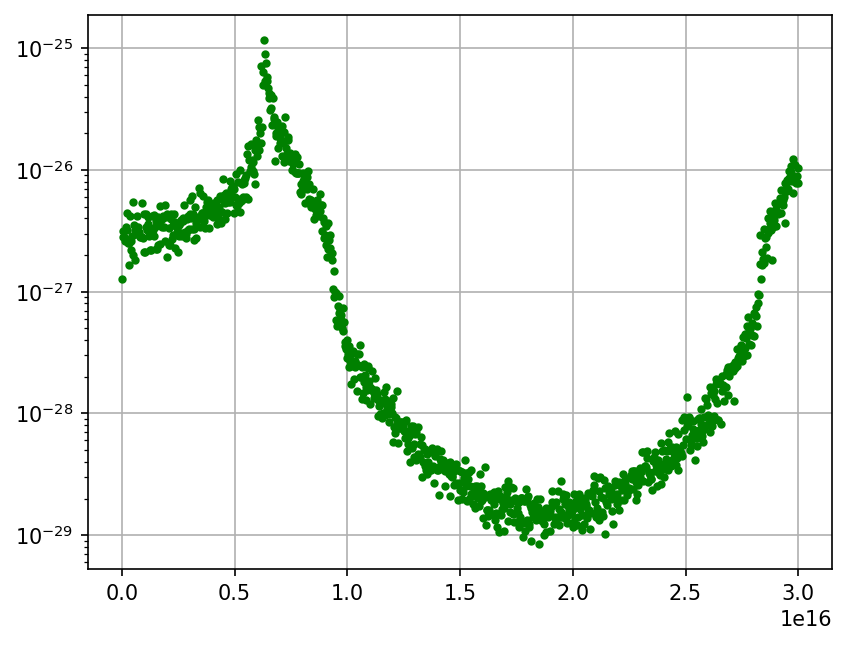

In [6]:
plt.figure(dpi=150)
freqs = np.linspace(0,30e15,1000)
plt.plot(freqs,Efavg*tsim*eps0*4*np.pi*3/2**21,'g''.')
#plt.xlim(4e15,20e15)
plt.yscale("log")
#plt.ylim(0.1e-28,4000e-28)
plt.grid()
plt.savefig('10_7ps.png')
plt.show()

np.savez("10_7ps.npz", Efavg_30000 = Efavg)